# Example

First thing first, imports

In [17]:
import os
import numpy as np
from torchvision import transforms
import torch
from astropy.io import fits

from inverse_problem.nn_inversion.main import HyperParams, Model
from inverse_problem import get_project_root
from inverse_problem.milne_edington.me import read_full_spectra
from inverse_problem.nn_inversion import models
from inverse_problem.nn_inversion.models import FullModel_no_cont

import json
from pprint import pprint
import matplotlib.pyplot as plt




Json file should contain parameters for data reading and transformation, parameters for model training

In [18]:
path_to_json = os.path.join(get_project_root(), 'res_experiments', 'hps_base_mlp.json')
with open(path_to_json) as f:
    json_data = json.load(f)
    pprint(json_data)

{'batch_size': 20,
 'bottom_net': 'BottomSimpleMLPNet',
 'bottom_output': 40,
 'cont_scale': 40000,
 'factors': [1, 1000, 1000, 1000],
 'hidden_size': 40,
 'logB': True,
 'n_epochs': 5,
 'n_input': 224,
 'per_epoch': 10,
 'predict_ind': [0, 1, 2],
 'source': 'database',
 'top_net': 'TopNet',
 'top_output': 3,
 'transform_type': 'mlp_transform_rescale'}


We will use simple multilayer perceptron in this example

In [22]:
# read params from json
hps = HyperParams.from_file(path_to_json=path_to_json)

# here we specify some training parameters
hps.n_epochs = 5
hps.batch_size = 100

# specify the number of training examples
hps.per_epoch = 1000


model = Model(hps)
top_net = getattr(models, hps.top_net)
bottom_net = getattr(models, hps.bottom_net)
model.net = FullModel_no_cont(hps, bottom_net, top_net)

In [23]:
model.net.bottom.fc2 = torch.nn.Linear(40, 41)

In [24]:
model.net

FullModel_no_cont(
  (bottom): BottomSimpleMLPNet(
    (fc1): Linear(in_features=224, out_features=40, bias=True)
    (fc2): Linear(in_features=40, out_features=41, bias=True)
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (top): TopNet(
    (fc1): Linear(in_features=41, out_features=40, bias=True)
    (fc2): Linear(in_features=40, out_features=3, bias=True)
    (dropout): Dropout(p=0.0, inplace=False)
  )
)

In [25]:
# and train it
history = model.train()



epoch: 100%|██████████| 5/5 [28:57<00:00, 347.46s/it]


torch.Size([100, 224])
torch.Size([100, 224])
torch.Size([100, 224])
torch.Size([100, 224])
torch.Size([100, 224])
torch.Size([100, 224])
torch.Size([100, 224])
torch.Size([100, 224])
torch.Size([100, 224])
torch.Size([100, 224])
torch.Size([100, 224])
torch.Size([100, 224])
torch.Size([100, 224])
torch.Size([100, 224])
torch.Size([100, 224])
torch.Size([100, 224])
torch.Size([100, 224])
torch.Size([100, 224])
torch.Size([100, 224])
torch.Size([100, 224])
torch.Size([100, 224])
torch.Size([100, 224])
torch.Size([100, 224])
torch.Size([100, 224])
torch.Size([100, 224])
torch.Size([100, 224])
torch.Size([100, 224])
torch.Size([100, 224])
torch.Size([100, 224])
torch.Size([100, 224])
torch.Size([100, 224])
torch.Size([100, 224])
torch.Size([100, 224])
torch.Size([100, 224])
torch.Size([100, 224])
torch.Size([100, 224])
torch.Size([100, 224])
torch.Size([100, 224])
torch.Size([100, 224])
torch.Size([100, 224])
torch.Size([100, 224])
torch.Size([100, 224])
torch.Size([100, 224])
torch.Size(

In [26]:
path_to_save = os.path.join(get_project_root(), 'checkpoints', 'mlp_example_no_cont.pt')
model.save_model(path_to_save)
# and load them
model.load_model(path_to_save)


Inference

In [27]:
filename = os.path.join(get_project_root(), 'data', '20170905_030404\\')
line, cont = read_full_spectra(filename)

100%|██████████| 485/485 [00:02<00:00, 185.01it/s]


In [28]:
line[1]

array([[ 9.84877687e-01,  9.87916976e-01,  9.80948851e-01, ...,
         8.89547813e-04,  7.78354337e-04,  6.67160860e-04],
       [ 9.84877687e-01,  9.87916976e-01,  9.80948851e-01, ...,
         8.89547813e-04,  7.78354337e-04,  6.67160860e-04],
       [ 9.84877687e-01,  9.87916976e-01,  9.80948851e-01, ...,
         8.89547813e-04,  7.78354337e-04,  6.67160860e-04],
       ...,
       [ 9.97222222e-01,  9.79320988e-01,  9.86959877e-01, ...,
        -2.89351852e-03, -3.12500000e-03, -3.81944444e-03],
       [ 9.92984968e-01,  9.76521117e-01,  9.78740157e-01, ...,
        -1.61059413e-03, -1.82534001e-03, -1.93271296e-03],
       [ 9.87489976e-01,  9.85565357e-01,  9.94306335e-01, ...,
         2.40577386e-04,  1.20288693e-04,  1.20288693e-04]])

In [29]:
def predict_full_image(x, parameter):

    line_ = torch.FloatTensor(x[0])
    cont_ = torch.FloatTensor(x[1])
    output = np.zeros(line_.shape[:2])
    model.net.eval()
    with torch.no_grad():
        for i in range(line_.shape[0]):
            pred = model.net(line_[i])
            # print(pred.shape) torch.Size([512, 3])
            output[i] = pred[:, parameter].T
    return output

predicted = predict_full_image((line, cont), 0)

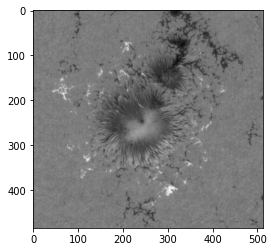

In [30]:
_ = plt.imshow(predicted, cmap='gray')

In [31]:
predicted[0]


array([0.02313069, 0.02313069, 0.02313069, 0.02313069, 0.02313069,
       0.02313069, 0.02303944, 0.02307879, 0.02357626, 0.02358164,
       0.02305625, 0.02333622, 0.02356881, 0.0225475 , 0.02317614,
       0.02372061, 0.02416356, 0.02277926, 0.0220663 , 0.02239544,
       0.02219535, 0.022965  , 0.02387675, 0.02431843, 0.02443338,
       0.02288879, 0.02315381, 0.02328555, 0.02265255, 0.02268632,
       0.02294384, 0.02244234, 0.02200892, 0.02243119, 0.02269942,
       0.02265416, 0.02304929, 0.02276519, 0.02247821, 0.02268342,
       0.02250423, 0.02361727, 0.02349886, 0.02358276, 0.02264933,
       0.02222677, 0.02189998, 0.02307567, 0.02223259, 0.02350701,
       0.02359608, 0.02455802, 0.02367314, 0.02408732, 0.02457385,
       0.02403263, 0.02392184, 0.02329599, 0.02343164, 0.02419563,
       0.02395626, 0.02281959, 0.02262261, 0.02313206, 0.02359839,
       0.02355424, 0.02264271, 0.02221432, 0.02271868, 0.02383341,
       0.02376524, 0.0241305 , 0.02463168, 0.02424824, 0.02492